In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fig_style import *

import sys
sys.path.insert(0,'../')
from disk_model import DiskFitting, DiskImage

import astropy.constants as const
au = const.au.cgs.value

In [2]:
with open("../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl","rb") as f:
    Ds = pickle.load(f)
from get_chi_sq import get_mean_chisq_mult, get_mean_chisq
chisq = get_mean_chisq_mult(Ds)

In [3]:
def get_D(i_chisq):
    return Ds[np.argsort(chisq)[i_chisq]]

In [4]:
def plot_img(I,fig_size_au,corner_text):
    xmax = I.img.shape[0]/2.*I.au_per_pix
    p=plt.imshow(I.img,origin='lower',extent=(-xmax,xmax,-xmax,xmax),cmap='jet',vmin=0)
    plt.xlim(-fig_size_au,fig_size_au)
    plt.ylim(-fig_size_au,fig_size_au)
    # plot beam
    th = np.linspace(0,2*np.pi,100)
    x0 = np.cos(th)*I.beam_min/2
    y0 = np.sin(th)*I.beam_maj/2
    dth = I.beam_pa/180*np.pi
    x = x0*np.cos(dth) - y0*np.sin(dth)
    y = x0*np.sin(dth) + y0*np.cos(dth)
    xc = fig_size_au*0.7
    yc = -fig_size_au*0.7
    plt.fill(x+xc,y+yc,'w')
    # text
    plt.text(plt.xlim()[0]*0.9, plt.ylim()[1]*0.9, corner_text, color='w', fontsize=11, va='top')
    x0,y0 = -fig_size_au*0.5, -fig_size_au*0.7
    # scale bar
    plt.plot([x0-50,x0+50],[y0,y0],'w',lw=2)
    plt.text(x0, y0-fig_size_au*0.08, '100 au', color='w', fontsize=10, va='top', ha='center')
    plt.gca().axis('off')
    # colorbar()
    cax = plt.gca().inset_axes([0, -0.1, 1, 0.08])
    cb = plt.colorbar(p, ax = plt.gca(), cax=cax, orientation='horizontal')
    cax.set_xlabel(r'Flux density [Jy/beam]')
    cax.xaxis.set_ticks_position('both')
    cax.tick_params('x',which='both',direction='in')

import scipy.ndimage as ndimage
def take_cut_and_plot(I,img,cut_deg,**kwargs):
    img = ndimage.interpolation.rotate(img,-cut_deg,reshape=False) # ccw rotate by cut_deg
    i0 = img.shape[1]//2
    x = (np.arange(2*i0+1)-i0) * I.au_per_pix
    y = img[:,i0]
    plt.plot(x,y,**kwargs)
    return x,y
def compare_img(I,fig_size_au,color,ylabel_text):
    x,y = take_cut_and_plot(I, I.img, -I.disk_pa, color='k')
    x2,y2 = take_cut_and_plot(I, I.img_model, -I.disk_pa, color=color, lw=2, alpha=0.8)
    ymax = max(np.amax(y*(np.abs(x)<fig_size_au)), np.amax(y2*(np.abs(x2)<fig_size_au)))
    plt.plot([-fig_size_au,fig_size_au], [I.rms_Jy, I.rms_Jy], 'k:', lw=.5)
    plt.legend(['observation','model',r'$\sigma_{\rm obs}$'], loc=2, frameon=False, handlelength=1)
    plt.xlim(-fig_size_au,fig_size_au)
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
    plt.xlabel('Offset along major axis [au]')
    plt.yscale('log')
    plt.ylim(I.rms_Jy/2,ymax*3)
    plt.ylabel(ylabel_text)
    set_ticks()
def plot_img_comparison(D, fig_size_au=200):
    
    w_ratios = np.array([0.6,1,1.6,1,1.6])
    w = w_ratios/np.sum(w_ratios)
    wl = np.cumsum(w)-w
    
    fig = plt.figure(figsize=(12,2.0))
    
    ax = fig.add_axes([wl[0], 0, w[0], 1])
    
    mean_chisq = get_mean_chisq(D)
    mean_chisq_a = D.mean_chisq_list[0]
    mean_chisq_v = D.mean_chisq_list[1]
    plt.text(
        0, 0, D.source_name+'\n\n'+\
        r'$\chi^2_{\rm mean}=$'+'{:.2f}\n\n'.format(mean_chisq)+\
        r'$\chi^2_{\rm A}=$'+'{:.2f}\n\n'.format(mean_chisq_a)+\
        r'$\chi^2_{\rm V}=$'+'{:.2f}'.format(mean_chisq_v),
        ha='left',va='center',fontsize=13,
    )
    plt.ylim(-1,1)
    plt.gca().axis('off')
    #print(D.disk_model.Rd/au)
    
    ax = fig.add_axes([wl[1], 0.1, w[1], 0.9])
    plot_img(D.disk_image_list[0],fig_size_au,'0.87 mm (ALMA)')
    
    eps = 0
    
    ax = fig.add_axes([wl[2]+w[2]*0.2, 0-eps, w[2]*0.7, 1+eps])
    compare_img(D.disk_image_list[0],fig_size_au*1.5,'tab:blue',r'$F_{0.87\rm mm}$ [Jy/beam]')
    
    ax = fig.add_axes([wl[3], 0.1, w[3], 0.9])
    plot_img(D.disk_image_list[1],fig_size_au,'9 mm (VLA)')
    
    ax = fig.add_axes([wl[4]+w[4]*0.2, 0-eps, w[4]*0.7, 1+eps])
    compare_img(D.disk_image_list[1],fig_size_au*1.5,'tab:orange',r'$F_{9\rm mm}$ [Jy/beam]')
        
    return fig

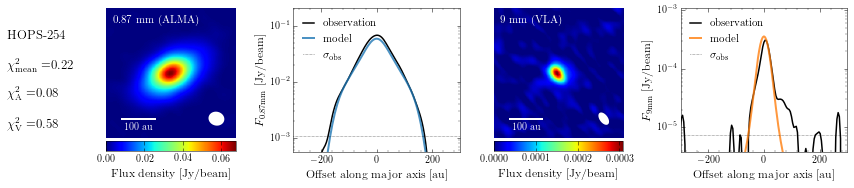

In [5]:
D = get_D(1)
_ = plot_img_comparison(D)
plt.savefig('../figures/compare_fit_with_img_1.pdf',bbox_inches='tight')

In [6]:
np.sum(chisq<=1)

89

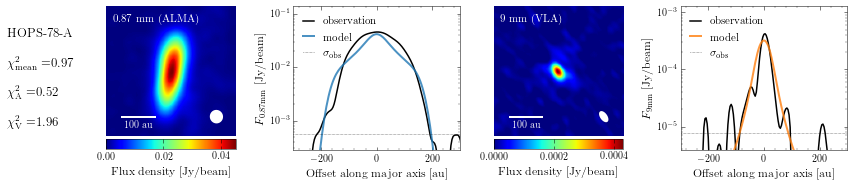

In [7]:
D = get_D(88)
_ = plot_img_comparison(D)
plt.savefig('../figures/compare_fit_with_img_2.pdf',bbox_inches='tight')

In [8]:
np.sum(chisq<=2)

115

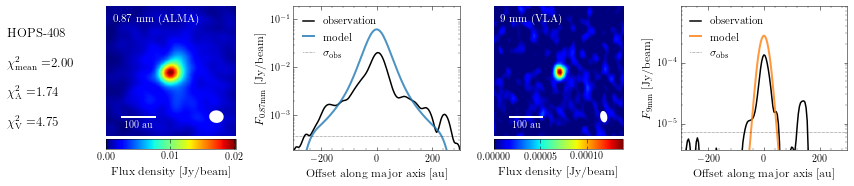

In [9]:
D = get_D(114)
_ = plot_img_comparison(D)
plt.savefig('../figures/compare_fit_with_img_3.pdf',bbox_inches='tight')

# Plot a random subsample

<ipython-input-4-2d7c2a64cb23>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,2.0))


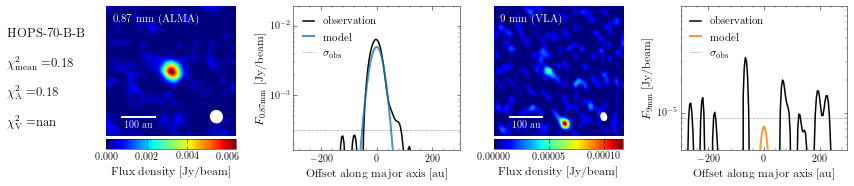

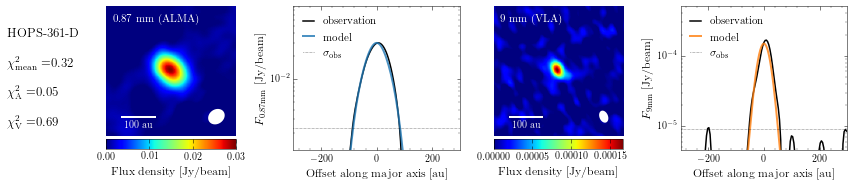

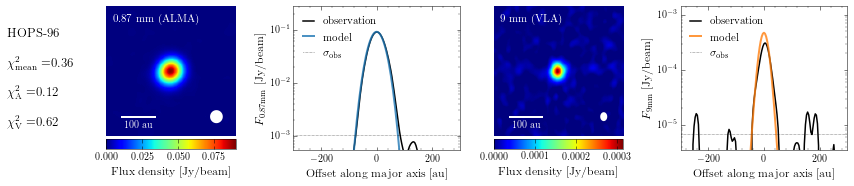

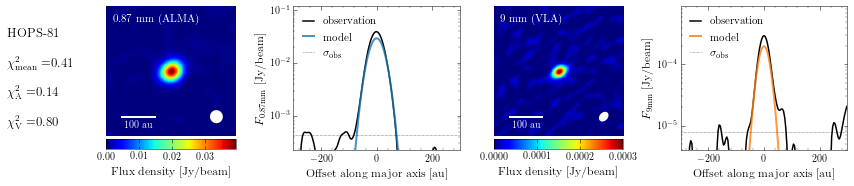

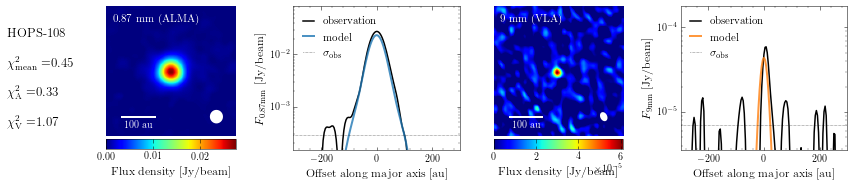

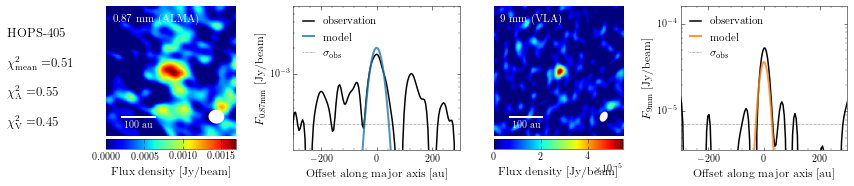

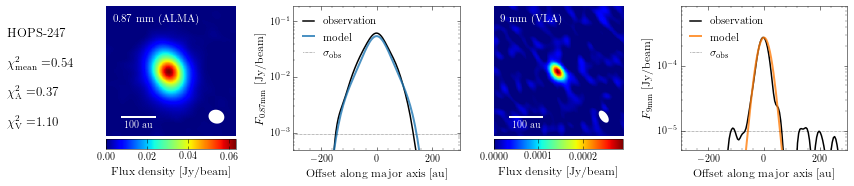

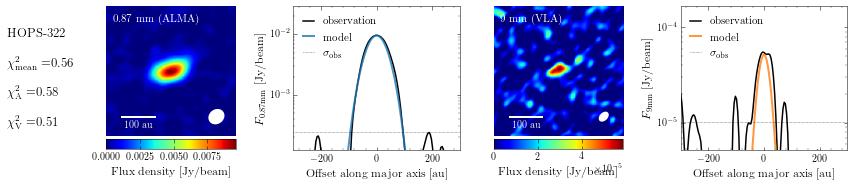

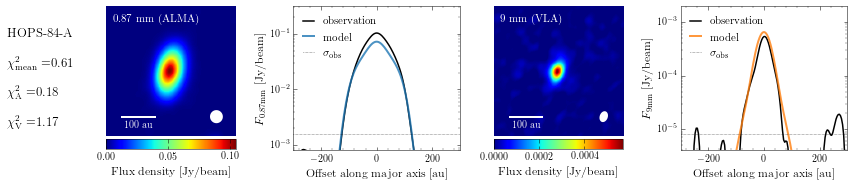

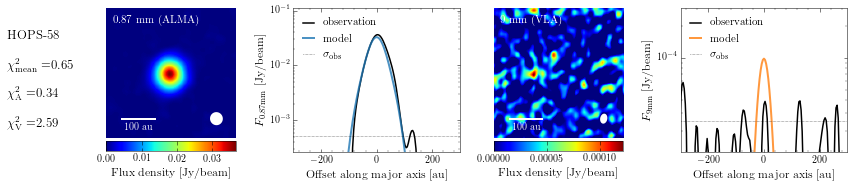

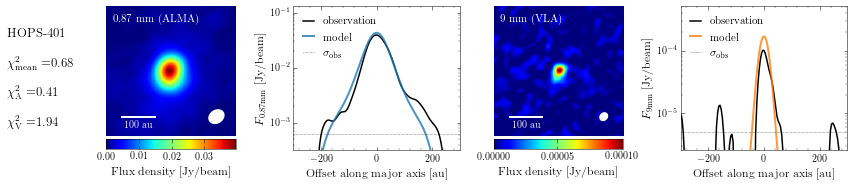

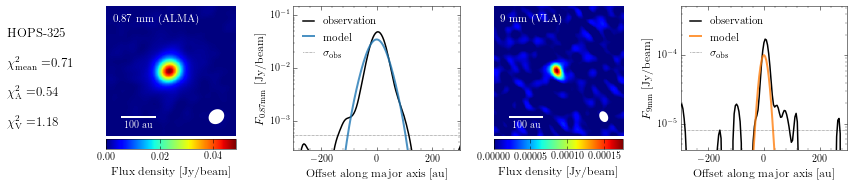

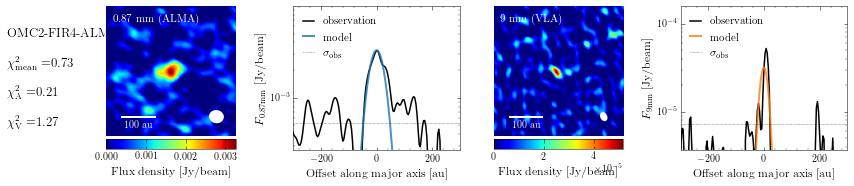

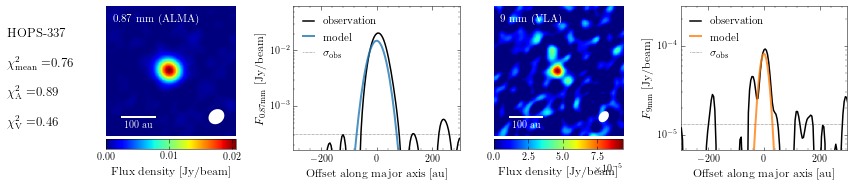

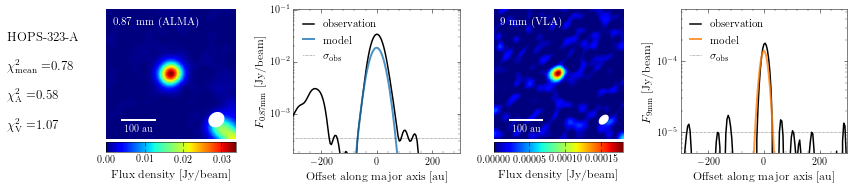

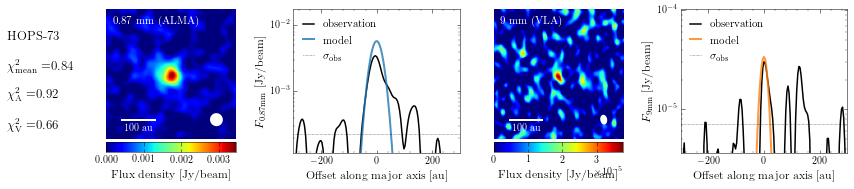

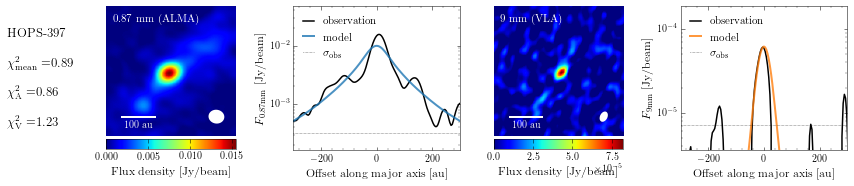

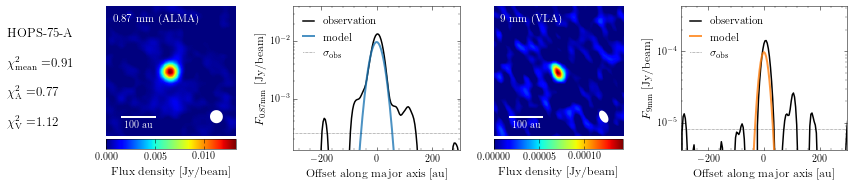

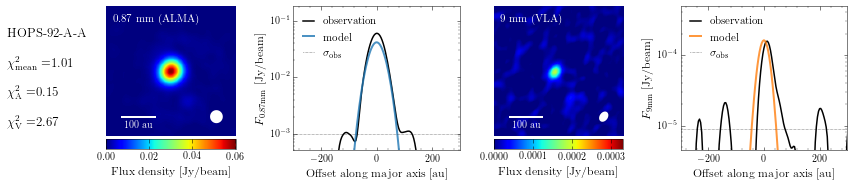

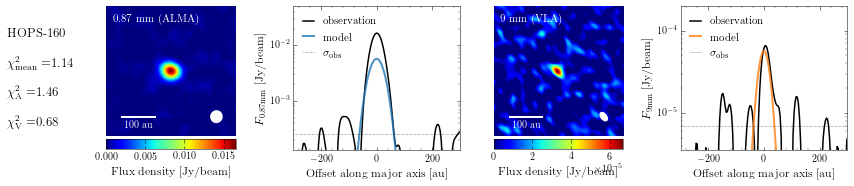

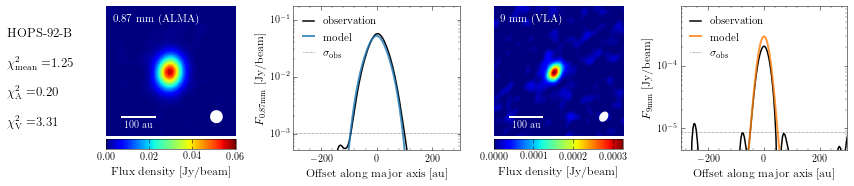

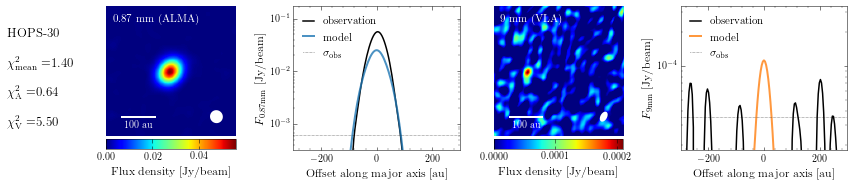

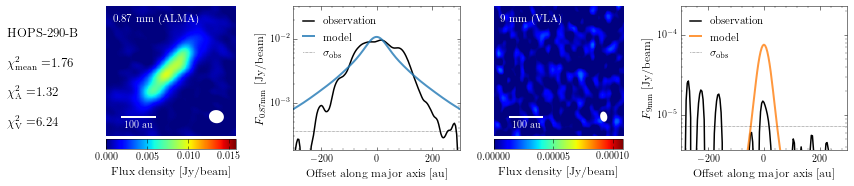

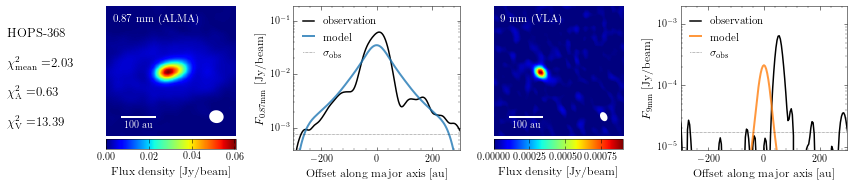

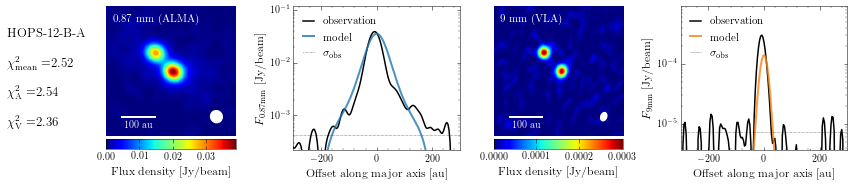

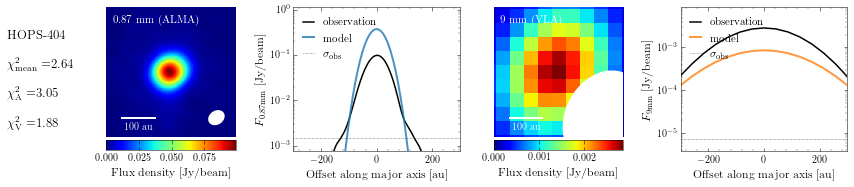

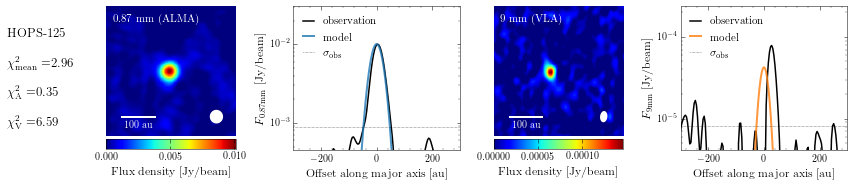

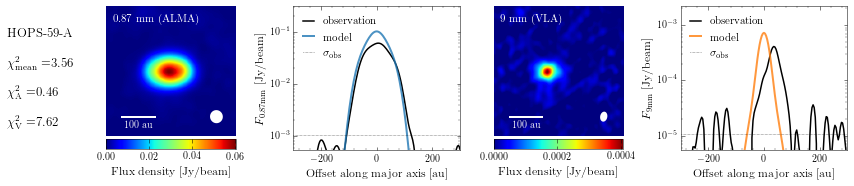

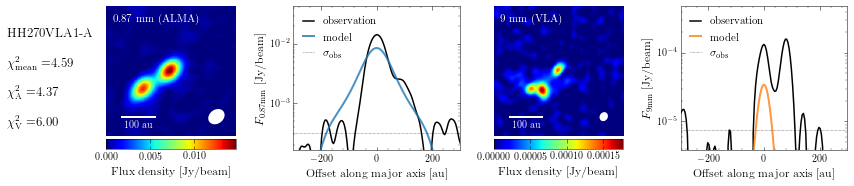

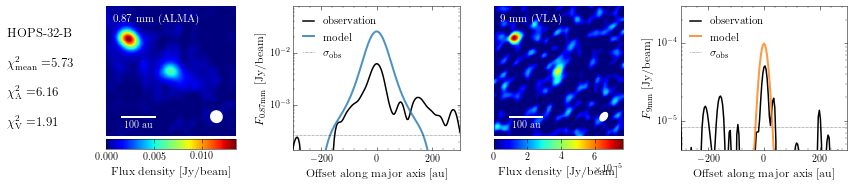

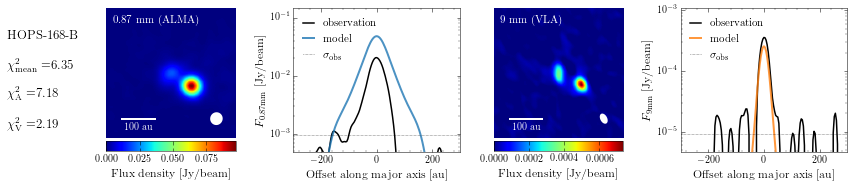

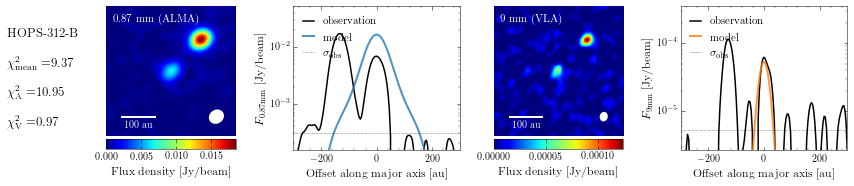

In [10]:
i_list = np.arange(0, len(chisq) ,5)
for i in i_list:
    D = get_D(i)
    _ = plot_img_comparison(D)